In [11]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import numpy as np
import datetime as dt

### Pull in SNTL Data, basins and closest sntl sites

In [2]:
#EPSG code
co_epsg = 32613
# UCRB Basins
ucrb_hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
ucrb_hcdn_basins = ucrb_hcdn_basins.set_crs(32613,allow_override=True)
# ucrb_hcdn_basins = ucrb_hcdn_basins.to_crs(co_epsg)
# pull in sntl
hcdn_sntl_swe_ds = xr.open_dataset('../data/snowdata/ucrb_hcdn_sntl_all_20220930.nc')

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [3]:
# Clean SNTL data
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC']>=0))
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC'].diff(dim='Date')<20))

# Open PRISM data

In [99]:
# Download PRISM normals 
outpath = '../data/precipdata/PRISM/PRISM_ppt_30yr_normal_4kmM4_all_bil/'
files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and ('annual' not in x)]
prism_list = []
for file in files:
       prism_list.append(rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry))
prism_normals_ds = xr.concat(prism_list, dim='band')
prism_normals_ds = prism_normals_ds.rename({'band':'month'})

prism_normals_ds = prism_normals_ds.assign_coords({
        'month': [1,2,3,4,5,6,7,8,9,10,11,12]})

if not os.path.exists('../data/precipdata/prism_4km_all.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '../data/precipdata/PRISM/PRISM_ppt_stable_4km/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry)
              prism_list.append(tmp)
       prism_4km_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_ds = prism_4km_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_ds = prism_4km_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_ds = prism_4km_ds.sortby('month')
       prism_4km_ds = prism_4km_ds.sel(month=slice('1981-01-01', '2022-09-01'))

In [5]:
# Download historic PRISM precipitation from 4km product 
if not os.path.exists('../data/precipdata/prism_4km_all.nc'):
       outpath = '/storage/dlhogan/sos/data/PRISM_ppt/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry)
              prism_list.append(tmp)
       prism_4km_historic_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_historic_ds = prism_4km_historic_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_historic_ds = prism_4km_historic_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_historic_ds = prism_4km_historic_ds.sortby('month')
       prism_4km_all_ds = xr.concat([prism_4km_historic_ds, prism_4km_ds], dim='month', join='override')
       prism_4km_all_ds.to_netcdf('../data/precipdata/prism_4km_all.nc')
else:
       prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_all.nc')

In [28]:
# Open PRISM 4km for the entire UCRB
prism_4km_ucrb_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
# convert month to datetime
prism_4km_ucrb_ds['month'] = pd.to_datetime(prism_4km_ucrb_ds['month'],format='%Y%m%d')

# Create a filter to remove dates after 1999-10-01
prism_4km_pre_ds = prism_4km_ucrb_ds.sel(month=slice('1963-10-01', '1999-09-30'))
prism_4km_post_ds = prism_4km_ucrb_ds.sel(month=slice('1999-10-01', '2022-09-30'))


### Download PRISM Temperatures

In [31]:
if not os.path.exists('../data/etdata/prism_tmean_4km_all.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '/storage/dlhogan/sos/data/PRISM/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 39)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rioxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry)
              prism_list.append(tmp)
       prism_4km_tmean_ds = xr.concat(prism_list, dim='band', join='override')
       prism_4km_tmean_ds = prism_4km_tmean_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_tmean_ds = prism_4km_tmean_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_tmean_ds = prism_4km_tmean_ds.sortby('month')
       prism_4km_tmean_ds = prism_4km_tmean_ds.sel(month=slice('1895-01-01', '2022-09-01'))

       prism_4km_tmean_ds.to_netcdf('../data/etdata/prism_tmean_4km_all.nc')
else:
       prism_4km_tmean_ds = xr.open_dataset('../data/etdata/prism_tmean_4km_all.nc')

In [34]:
# For normals product
# Filter out bad data
# prism_normals_ds_ma = prism_normals_ds.where(prism_normals_ds>=0).sum(dim='month')

# Reproject the masked dataset and clip to HCDN boundaries
# prism_normals_hcdn_ds = prism_normals_ds_ma.rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry)

# Filter out other bad data
# prism_normals_hcdn_ds_ma = prism_normals_ds_ma.where((prism_normals_ds>=0) & (prism_normals_ds_ma<5000))

# For 4 km product
# Filter out bad data
prism_4km_all_ds_ma = prism_4km_all_ds.where(prism_4km_all_ds>=0)
prism_4km_tmean_ds_ma = prism_4km_tmean_ds.where(prism_4km_tmean_ds>=-50)
# Reproject the masked dataset and clip to HCDN boundaries
# prism_4km_hcdn_ds = prism_4km_ds_ma.rio.reproject(co_epsg).rio.clip(ucrb_hcdn_basins.geometry)

# Filter out other bad data
prism_4km_hcdn_ds_ma = prism_4km_all_ds_ma.where((prism_4km_all_ds_ma<5000) & (prism_4km_all_ds_ma>=0))
# prism_4km_hcdn_ds_ma.name = 'ppt'
prism_4km_hcdn_ds_ma=prism_4km_hcdn_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})

prism_4km_tmean_hcdn_ds_ma = prism_4km_tmean_ds_ma.where((prism_4km_tmean_ds_ma<100) & (prism_4km_tmean_ds_ma>=-100))
# prism_4km_tmean_hcdn_ds_ma.name = 'tmean'
prism_4km_tmean_hcdn_ds_ma=prism_4km_tmean_hcdn_ds_ma.rename_vars({'__xarray_dataarray_variable__':'tmean'})

### Functions for computing seasonal precipitation totals and anomalies

In [35]:
# Seasonal Precipitation Plot
def season_sum(ds, calendar="standard"):

    # Calculate the weighted average
    return (ds).resample(month='QS-DEC').mean() * 3

def season_mean(ds, calendar="standard"):

    # Calculate the weighted average
    return (ds).resample(month='QS-DEC').mean()

def annual_sum(ds, calendar="standard"):

    # Calculate the weighted average
    return ds.resample(month='A-OCT').sum()

def annual_mean(ds, calendar="standard"):

    # Calculate the weighted average
    return ds.resample(month='A-OCT').mean()

def get_monthly_prism_anomalies(ds):
    # Get monthly normalized values of sublimation/evaporation and precipitation
    ds_mean = ds.groupby('month.month').mean("month")
    ds_std = ds.groupby('month.month').std("month")

    stand_anomalies = xr.apply_ufunc(
        lambda x,m,s: (x-m)/s,
        ds.groupby("month.month"),
        ds_mean,
        ds_std,
        dask='parallelized'
    )
    return stand_anomalies

In [36]:
# Seasonal PRISM sum for precipitation at each grid cell
prism_4km_hcdn_seasonal_ds = season_sum(prism_4km_hcdn_ds_ma)
prism_4km_hcdn_seasonal_ma_ds = prism_4km_hcdn_seasonal_ds.where(prism_4km_hcdn_seasonal_ds>0)

# Annual PRISM sum for precipitation at each grid cell
prism_4km_hcdn_annual_ds = annual_sum(prism_4km_hcdn_seasonal_ds)
prism_4km_hcdn_annual_ds_ma_ds = prism_4km_hcdn_annual_ds.where(prism_4km_hcdn_annual_ds>0)

# Seasonal PRISM mean for temperature at each grid cell
prism_4km_hcdn_tmean_seasonal_ds = season_mean(prism_4km_tmean_hcdn_ds_ma)
prism_4km_hcdn_tmean_seasonal_ma_ds = prism_4km_hcdn_tmean_seasonal_ds.where(prism_4km_hcdn_tmean_seasonal_ds>-100)

# Annual PRISM mean for temperature at each grid cell
prism_4km_hcdn_tmean_annual_ds = annual_mean(prism_4km_tmean_hcdn_ds_ma)
prism_4km_hcdn_tmean_annual_ds_ma_ds = prism_4km_hcdn_tmean_annual_ds.where(prism_4km_hcdn_tmean_annual_ds>100)

In [56]:
# Compute the seasonal sum for pre and post ucrb prism
prism_4km_pre_seasonal_ds = season_mean(prism_4km_pre_ds)
prism_4km_pre_seasonal_ds_ma = prism_4km_pre_seasonal_ds.where(prism_4km_pre_seasonal_ds>0)

prism_4km_post_seasonal_ds = season_mean(prism_4km_post_ds)
prism_4km_post_seasonal_ds_ma = prism_4km_post_seasonal_ds.where(prism_4km_post_seasonal_ds>0)

# Compute the annual mean for pre and post ucrb prism
prism_4km_pre_annual_ds = annual_mean(prism_4km_pre_ds)
prism_4km_pre_annual_ds_ma = prism_4km_pre_annual_ds.where(prism_4km_pre_annual_ds>0)
prism_4km_post_annual_ds = annual_mean(prism_4km_post_ds)
prism_4km_post_annual_ds_ma = prism_4km_post_annual_ds.where(prism_4km_post_annual_ds>0)

# for all of these new products, rename __xarray_dataarray_variable__ to ppt
prism_4km_pre_seasonal_ds_ma=prism_4km_pre_seasonal_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})
prism_4km_post_seasonal_ds_ma=prism_4km_post_seasonal_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})
prism_4km_pre_annual_ds_ma=prism_4km_pre_annual_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})
prism_4km_post_annual_ds_ma=prism_4km_post_annual_ds_ma.rename_vars({'__xarray_dataarray_variable__':'ppt'})

In [70]:
def mean_percent_diff(ds1, ds2, month):
    if month is None:
        ds1_pre = ds1.mean(dim='month')
        ds2_post = ds2.mean(dim='month')
    else:
        ds1_pre = ds1.where(ds1.month.dt.month==month).mean(dim='month')
        ds2_post = ds2.where(ds2.month.dt.month==month).mean(dim='month')
    return (ds2_post-ds1_pre)

Text(0.5, 1.0, 'Precipitation Difference Between\nPeriod Means for Annual')

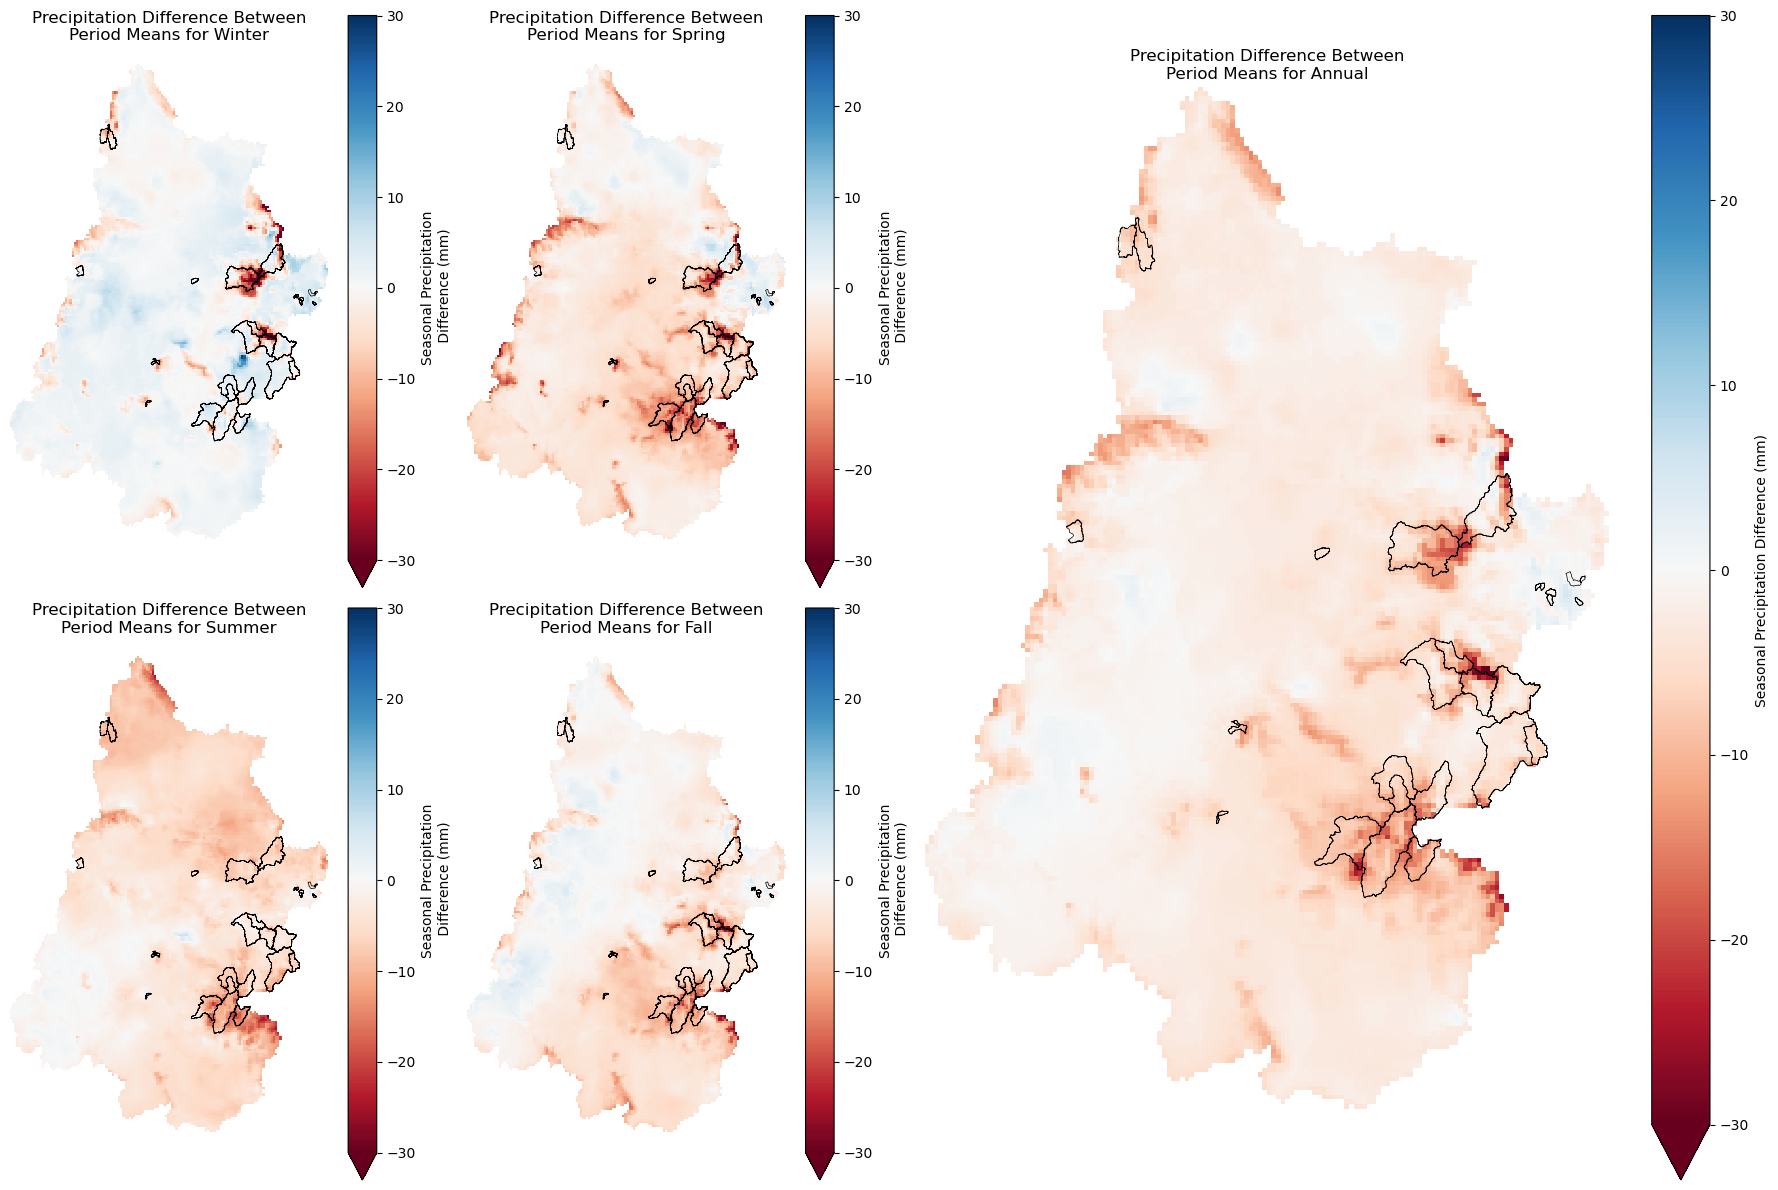

In [92]:
# Create subplots for each season 12,3,6,9 and the annual (using ggplot) and plot the mean percent difference
labels = ['Winter', 'Spring', 'Summer', 'Fall']
fig = plt.figure(figsize=(18, 12), tight_layout=True)
ax1 = plt.subplot2grid((2,4),(0,0))
ax2 = plt.subplot2grid((2,4),(0,1))
ax3 = plt.subplot2grid((2,4),(1,0))
ax4 = plt.subplot2grid((2,4),(1,1))
ax5 = plt.subplot2grid((2,4),(0,2), colspan=2, rowspan=2)
axs = [ax1, ax2, ax3, ax4, ax5]

for i, month in enumerate([12,3,6,9]):
    mean_percent_diff(prism_4km_pre_seasonal_ds_ma, prism_4km_post_seasonal_ds_ma, month)['ppt'].plot(ax=axs[i], cmap='RdBu', vmin=-30, vmax=30)
    axs[i].set_title('Precipitation Difference Between\nPeriod Means for {}'.format(labels[i]))
    axs[i].set_axis_off()
    # set the colorbar label to be Percent Difference
    cbar = axs[i].collections[0].colorbar
    cbar.set_label('Seasonal Precipitation\n Difference (mm)')
    # plot the hcdn basins
    ucrb_hcdn_basins.plot(ax=axs[i], facecolor="none", edgecolor="black", linewidth=0.5)
# add another plot for the annual mean

mean_percent_diff(prism_4km_pre_annual_ds_ma, prism_4km_post_annual_ds_ma, None)['ppt'].plot(ax=axs[4], cmap='RdBu', vmin=-30, vmax=30)
# set the colorbar label to be Percent Difference
cbar = axs[4].collections[0].colorbar
cbar.set_label('Seasonal Precipitation Difference (mm)')
# plot the hcdn basins
ucrb_hcdn_basins.plot(ax=axs[4], facecolor="none", edgecolor="black", linewidth=0.5)
axs[4].set_axis_off()
# add title to axs[4]
axs[4].set_title('Precipitation Difference Between\nPeriod Means for Annual')

### Create plot for PRISM normals

In [105]:
# all values less than zero are nan
prism_normals_ds = prism_normals_ds.where(prism_normals_ds>0)
# compute the mean for each season (DJF, MAM, JJA, SON)
prism_normals_winter_ds = prism_normals_ds.where((prism_normals_ds.month==12) | (prism_normals_ds.month==1) | (prism_normals_ds.month==2)).sum(dim='month')
prism_normals_spring_ds = prism_normals_ds.where((prism_normals_ds.month==3) | (prism_normals_ds.month==4) | (prism_normals_ds.month==5)).sum(dim='month')
prism_normals_summer_ds = prism_normals_ds.where((prism_normals_ds.month==6) | (prism_normals_ds.month==7) | (prism_normals_ds.month==8)).sum(dim='month')
prism_normals_fall_ds = prism_normals_ds.where((prism_normals_ds.month==9) | (prism_normals_ds.month==10) | (prism_normals_ds.month==11)).sum(dim='month')

# compute annual mean normals
prism_normals_annual_ds = prism_normals_ds.sum(dim='month')
prism_normals_annual_ds = prism_normals_annual_ds.where(prism_normals_annual_ds>0)

# compute the percent of annual precipitation that falls in each season
prism_normals_winter_annual_percent_ds = (prism_normals_winter_ds/prism_normals_annual_ds) * 100
prism_normals_spring_annual_percent_ds = (prism_normals_spring_ds/prism_normals_annual_ds) * 100
prism_normals_summer_annual_percent_ds = (prism_normals_summer_ds/prism_normals_annual_ds) * 100
prism_normals_fall_annual_percent_ds = (prism_normals_fall_ds/prism_normals_annual_ds) * 100

Text(0.5, 1.0, 'Annual Precipitation')

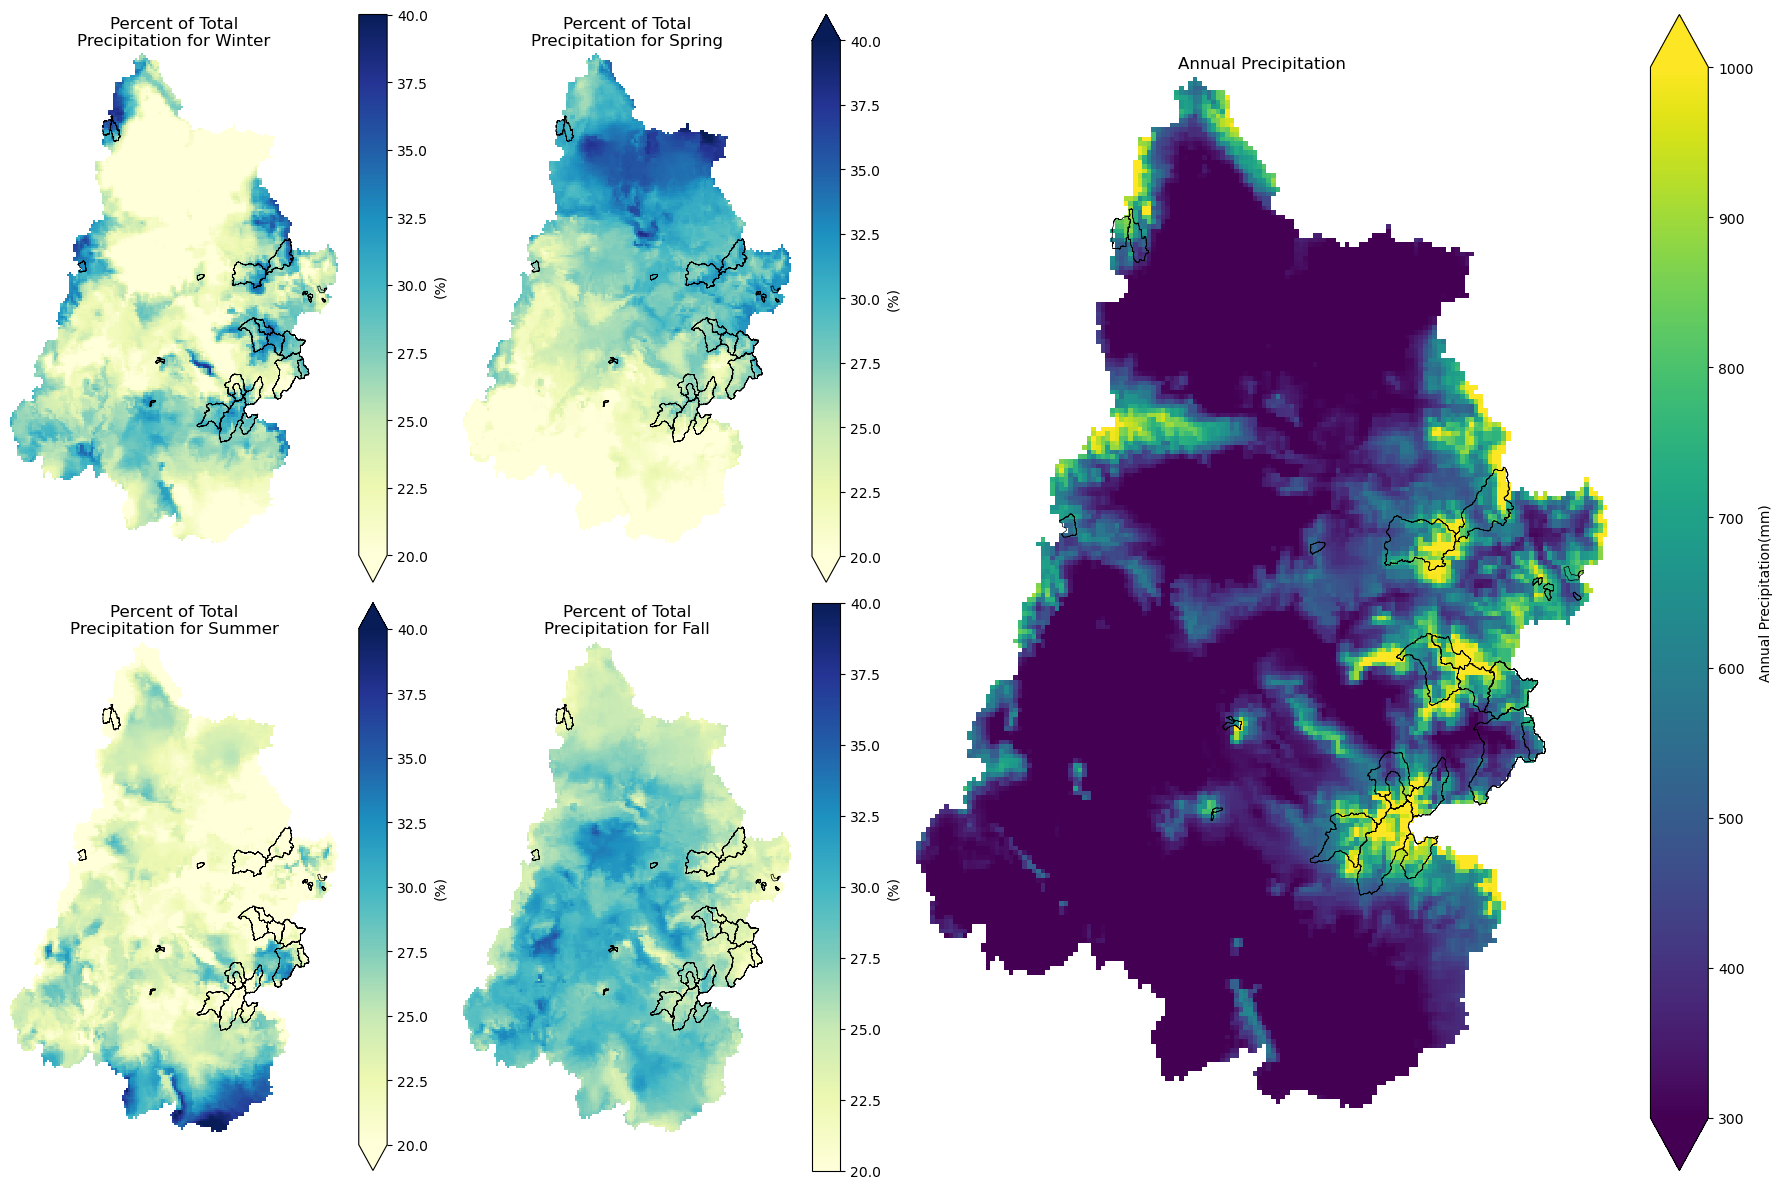

In [112]:
# Create subplots for each season 12,3,6,9 and the annual (using ggplot) and plot the mean percent difference
labels = ['Winter', 'Spring', 'Summer', 'Fall']
fig = plt.figure(figsize=(18, 12), tight_layout=True)
ax1 = plt.subplot2grid((2,4),(0,0))
ax2 = plt.subplot2grid((2,4),(0,1))
ax3 = plt.subplot2grid((2,4),(1,0))
ax4 = plt.subplot2grid((2,4),(1,1))
ax5 = plt.subplot2grid((2,4),(0,2), colspan=2, rowspan=2)
axs = [ax1, ax2, ax3, ax4, ax5]

for i, ds in enumerate([prism_normals_winter_annual_percent_ds,
                        prism_normals_spring_annual_percent_ds,
                        prism_normals_summer_annual_percent_ds,
                        prism_normals_fall_annual_percent_ds]):
    ds.plot(ax=axs[i], cmap='YlGnBu', vmin=20, vmax=40)
    axs[i].set_title('Percent of Total\nPrecipitation for {}'.format(labels[i]))
    axs[i].set_axis_off()
    # set the colorbar label to be Percent Difference
    cbar = axs[i].collections[0].colorbar
    cbar.set_label('(%)')
    # plot the hcdn basins
    ucrb_hcdn_basins.plot(ax=axs[i], facecolor="none", edgecolor="black", linewidth=0.5)
# add another plot for the annual mean

prism_normals_annual_ds.plot(ax=axs[4], cmap='viridis', vmin=300, vmax=1000)
# set the colorbar label to be Percent Difference
cbar = axs[4].collections[0].colorbar
cbar.set_label('Annual Precipitation(mm)')
# plot the hcdn basins
ucrb_hcdn_basins.plot(ax=axs[4], facecolor="none", edgecolor="black", linewidth=0.5)
axs[4].set_axis_off()
# add title to axs[4]
axs[4].set_title('Annual Precipitation')

In [192]:
prism_4km_hcdn_seasonal_ma_ds.to_netcdf('../data/precipdata/prism_4km_hcdn_seasonal.nc')
prism_4km_hcdn_annual_ds_ma_ds.to_netcdf('../data/precipdata/prism_4km_hcdn_annual.nc')

In [193]:
# First lets try with a single basin

def basinPRISM(ds,basin,tmean=False):
    ds_out = ds.rio.write_crs(co_epsg).rio.clip(basin.geometry)
    if not tmean:
        ds_out= ds_out.mean(dim=['x','y']) #* np.full(len(ds_out.month), basin.basin_area, dtype=float)
    else:
        ds_out= ds_out.mean(dim=['x','y'])
    # add water year
    ds_out['WY_sep'] = ds_out.month.dt.year.where(ds_out.month.dt.month < 9, ds_out.month.dt.year + 1)
    return ds_out

In [194]:
basin_seasonal_ppt_fractions = {}
for gage in ucrb_hcdn_basins.gage: # Tomchi Creek at Gunnison
    
    single_basin = ucrb_hcdn_basins[ucrb_hcdn_basins.gage==gage]
    single_basin_ds = basinPRISM(prism_4km_hcdn_ds_ma,single_basin).to_dataframe()

    single_basin_seasonal_ds = basinPRISM(prism_4km_hcdn_seasonal_ma_ds,single_basin).to_dataframe()

    # Make seasonal fractions of total precipitation
    single_basin_seasonal_fraction = pd.DataFrame(single_basin_seasonal_ds['ppt'] / single_basin_seasonal_ds.groupby('WY_sep')['ppt'].transform('sum'))
    # Add water year
    single_basin_seasonal_fraction['WY'] = single_basin_seasonal_fraction.index.year.where(single_basin_seasonal_fraction.index.month < 9, single_basin_seasonal_fraction.index.year + 1)
    # remove 2023
    single_basin_seasonal_fraction = single_basin_seasonal_fraction[single_basin_seasonal_fraction['WY']!=2023]
    # add to dictionary
    basin_seasonal_ppt_fractions[gage] = single_basin_seasonal_fraction

In [195]:
basin_seasonal_ppt = {}
for gage in ucrb_hcdn_basins.gage: # Tomchi Creek at Gunnison
    
    single_basin = ucrb_hcdn_basins[ucrb_hcdn_basins.gage==gage]
    single_basin_ds = basinPRISM(prism_4km_hcdn_ds_ma,single_basin).to_dataframe()

    single_basin_seasonal_ds = basinPRISM(prism_4km_hcdn_seasonal_ma_ds,single_basin).to_dataframe()
    single_basin_seasonal_ds['ppt_area_norm'] = single_basin_seasonal_ds['ppt'] / 30.437 / 3
    # Add water year
    single_basin_seasonal_ds['WY'] = single_basin_seasonal_ds.index.year.where(single_basin_seasonal_ds.index.month < 9, single_basin_seasonal_ds.index.year + 1)
    # remove 2023
    single_basin_seasonal_ds = single_basin_seasonal_ds[single_basin_seasonal_ds['WY']!=2023]
    # add to dictionary
    basin_seasonal_ppt[gage] = single_basin_seasonal_ds

In [196]:
basin_seasonal_tmean = {}
for gage in ucrb_hcdn_basins.gage: # Tomchi Creek at Gunnison
    
    single_basin = ucrb_hcdn_basins[ucrb_hcdn_basins.gage==gage]
    single_basin_ds = basinPRISM(prism_4km_tmean_hcdn_ds_ma,single_basin,tmean=True).to_dataframe()

    single_basin_seasonal_ds = basinPRISM(prism_4km_hcdn_tmean_seasonal_ma_ds,single_basin,tmean=True).to_dataframe()

    # Make seasonal fractions of total precipitation
    single_basin_seasonal_tmean = pd.DataFrame(single_basin_seasonal_ds['tmean'])
    # Add water year
    single_basin_seasonal_tmean['WY'] = single_basin_seasonal_tmean.index.year.where(single_basin_seasonal_tmean.index.month < 9, single_basin_seasonal_tmean.index.year + 1)
    # remove 2023
    single_basin_seasonal_tmean = single_basin_seasonal_tmean[single_basin_seasonal_tmean['WY']!=2023]
    # add to dictionary
    basin_seasonal_tmean[gage] = single_basin_seasonal_tmean

In [197]:
basin_seasonal_ppt_fractions_ds = xr.Dataset(basin_seasonal_ppt_fractions).to_array()
basin_seasonal_tmean_ds = xr.Dataset(basin_seasonal_tmean).to_array()
basin_seasonal_ppt_ds = xr.Dataset(basin_seasonal_ppt).to_array()

In [198]:
basin_seasonal_tmean_ds.to_netcdf('../data/precipdata/prism_hcdn_seasonal_tmean.nc')
basin_seasonal_ppt_ds.to_netcdf('../data/precipdata/prism_hcdn_seasonal_ppt.nc')

In [199]:
winter_spring_mean_P = basin_seasonal_ppt_ds.sel(dim_1=['ppt_area_norm']).where(basin_seasonal_ppt_ds.month.dt.month.isin([12,3])).resample(month='1Y').mean()

In [201]:
drought_1930s = slice('1932-09-01','1936-08-31')
drought_1970s = slice('1977-09-01','1981-08-31')
drought_1980s = slice('1988-09-01','1993-08-31')
drought_2000s = slice('2000-09-01','2005-08-31')
drought_2010s = slice('2017-09-01','2022-08-31')

Text(0.5, 0, 'Basin Area (km$^2$)')

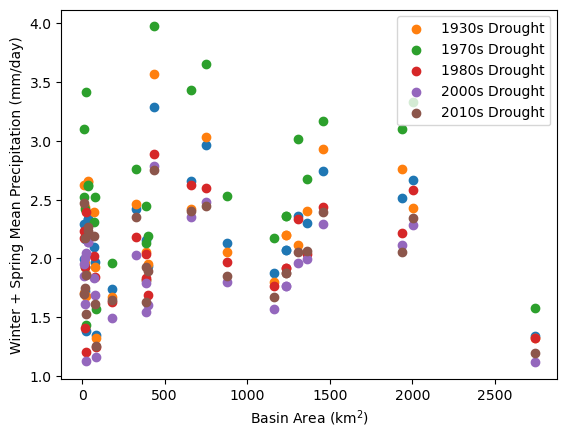

In [202]:
plt.scatter( ucrb_hcdn_basins.basin_area/1e6,winter_spring_mean_P.mean(dim='month').values)
plt.scatter(ucrb_hcdn_basins.basin_area/1e6,winter_spring_mean_P.sel(month=drought_1930s).mean(dim='month').values, label='1930s Drought')
plt.scatter(ucrb_hcdn_basins.basin_area/1e6,winter_spring_mean_P.sel(month=drought_1970s).mean(dim='month').values, label='1970s Drought')
plt.scatter(ucrb_hcdn_basins.basin_area/1e6,winter_spring_mean_P.sel(month=drought_1980s).mean(dim='month').values, label='1980s Drought')
plt.scatter(ucrb_hcdn_basins.basin_area/1e6,winter_spring_mean_P.sel(month=drought_2000s).mean(dim='month').values, label='2000s Drought')
plt.scatter(ucrb_hcdn_basins.basin_area/1e6,winter_spring_mean_P.sel(month=drought_2010s).mean(dim='month').values, label='2010s Drought')
plt.legend()
plt.ylabel('Winter + Spring Mean Precipitation (mm/day)')
plt.xlabel('Basin Area (km$^2$)')

### Open DEM and get elevations for each basin

In [203]:
ucrb_dem = rioxr.open_rasterio('../basin_characteristics/ucrb_dem_150m.tif')

In [204]:
basin_mean_elevations = {}
for gage in ucrb_hcdn_basins.gage:
    basin = ucrb_hcdn_basins[ucrb_hcdn_basins.gage==gage]
    clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
    clipped_dem_ma = clipped_dem.where(clipped_dem>0)
    basin_mean_elevations[gage] = clipped_dem_ma.mean().values

# need to sort these together

Text(0.5, 0, 'Basin Mean Elevation (m)')

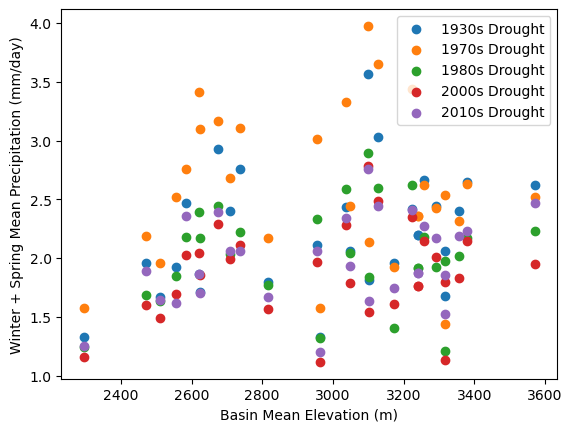

In [205]:
plt.scatter(basin_mean_elevations.values(),winter_spring_mean_P.sel(month=drought_1930s).mean(dim='month').values, label='1930s Drought')
plt.scatter(basin_mean_elevations.values(),winter_spring_mean_P.sel(month=drought_1970s).mean(dim='month').values, label='1970s Drought')
plt.scatter(basin_mean_elevations.values(),winter_spring_mean_P.sel(month=drought_1980s).mean(dim='month').values, label='1980s Drought')
plt.scatter(basin_mean_elevations.values(),winter_spring_mean_P.sel(month=drought_2000s).mean(dim='month').values, label='2000s Drought')
plt.scatter(basin_mean_elevations.values(),winter_spring_mean_P.sel(month=drought_2010s).mean(dim='month').values, label='2010s Drought')
plt.legend()
plt.ylabel('Winter + Spring Mean Precipitation (mm/day)')
plt.xlabel('Basin Mean Elevation (m)')

In [206]:
spring_precip_ranks = basin_seasonal_ppt_fractions_ds.where(basin_seasonal_ppt_fractions_ds.month.dt.month==3).sel(dim_1='ppt').mean(dim='variable').dropna(dim='month').rank(dim='month', pct=True)
summer_precip_ranks = basin_seasonal_ppt_fractions_ds.where(basin_seasonal_ppt_fractions_ds.month.dt.month==6).sel(dim_1='ppt').mean(dim='variable').dropna(dim='month').rank(dim='month', pct=True)
fall_precip_ranks = basin_seasonal_ppt_fractions_ds.where(basin_seasonal_ppt_fractions_ds.month.dt.month==9).sel(dim_1='ppt').mean(dim='variable').dropna(dim='month').rank(dim='month', pct=True)
winter_precip_ranks = basin_seasonal_ppt_fractions_ds.where(basin_seasonal_ppt_fractions_ds.month.dt.month==12).sel(dim_1='ppt').mean(dim='variable').dropna(dim='month').rank(dim='month', pct=True)

In [207]:
spring_tmean_ranks = basin_seasonal_tmean_ds.where(basin_seasonal_tmean_ds.month.dt.month==3).sel(dim_1='tmean').mean(dim='variable').dropna(dim='month').rank(dim='month', pct=True)
summer_tmean_ranks = basin_seasonal_tmean_ds.where(basin_seasonal_tmean_ds.month.dt.month==6).sel(dim_1='tmean').mean(dim='variable').dropna(dim='month').rank(dim='month', pct=True)
fall_tmean_ranks = basin_seasonal_tmean_ds.where(basin_seasonal_tmean_ds.month.dt.month==9).sel(dim_1='tmean').mean(dim='variable').dropna(dim='month').rank(dim='month', pct=True)
winter_tmean_ranks = basin_seasonal_tmean_ds.where(basin_seasonal_tmean_ds.month.dt.month==12).sel(dim_1='tmean').mean(dim='variable').dropna(dim='month').rank(dim='month', pct=True)

### Designate drought periods:
drought_1930s = slice('')
drought_1970s = slice('')
drought_1980s = slice('')
drought_2000s = slice('')
drought_2010s = slice('')

In [208]:
drought_1930s = slice('1932-09-01','1936-08-31')
drought_1970s = slice('1977-09-01','1981-08-31')
drought_1980s = slice('1988-09-01','1993-08-31')
drought_2000s = slice('2000-09-01','2005-08-31')
drought_2010s = slice('2017-09-01','2022-08-31')

In [209]:
seasonal_drought_1930s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_1930s)
seasonal_means_drought_1930s = seasonal_drought_1930s.groupby(seasonal_drought_1930s.month.dt.month).mean().to_series()

seasonal_drought_1970s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_1970s)
seasonal_means_drought_1970s = seasonal_drought_1970s.groupby(seasonal_drought_1970s.month.dt.month).mean().to_series()

seasonal_drought_1980s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_1980s)
seasonal_means_drought_1980s = seasonal_drought_1980s.groupby(seasonal_drought_1980s.month.dt.month).mean().to_series()

seasonal_drought_2000s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_2000s)
seasonal_means_drought_2000s = seasonal_drought_2000s.groupby(seasonal_drought_2000s.month.dt.month).mean().to_series()

seasonal_drought_2010s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_2010s)
seasonal_means_drought_2010s = seasonal_drought_2010s.groupby(seasonal_drought_2010s.month.dt.month).mean().to_series()

In [210]:
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

def stylize_axes(ax, title, xlabel, ylabel, xticks, xticklabels):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    
    
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xticks(xticks)
    # ax.set_yticks(yticks)
    
    ax.set_xticklabels(xticklabels)
    # ax.set_yticklabels(yticklabels)
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True, 
    left=True ,    # ticks along the bottom edge are off
    top=False,
    right=False)         # ticks along the top edge are off)

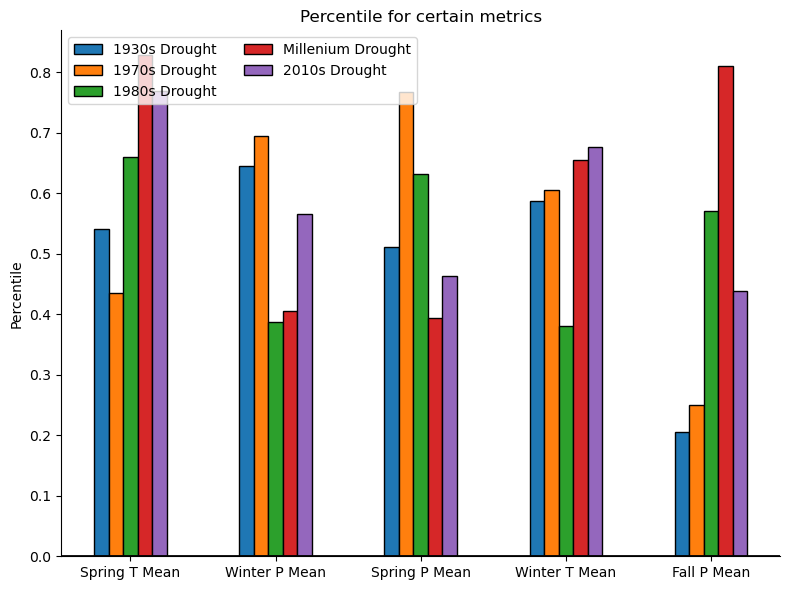

In [211]:
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True, sharex=True)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
x1 = [0,1,2,3,4]
x2 = [0.1,1.1,2.1,3.1,4.1]
x3 = [0.2,1.2,2.2,3.2,4.2]
x4 = [0.3,1.3,2.3,3.3,4.3]
x5 = [0.4,1.4,2.4,3.4,4.4]
location = [x1,x2,x3,x4,x5]
drought_1 = [
    spring_tmean_ranks.sel(month=drought_1930s).to_series().mean(),
    winter_precip_ranks.sel(month=drought_1930s).to_series().mean(),
    spring_precip_ranks.sel(month=drought_1930s).to_series().mean(),
    winter_tmean_ranks.sel(month=drought_1930s).to_series().mean(),
    fall_precip_ranks.sel(month=drought_1930s).to_series().mean(),
    ]
drought_2 = [
    spring_tmean_ranks.sel(month=drought_1970s).to_series().mean(),
    winter_precip_ranks.sel(month=drought_1970s).to_series().mean(),
    spring_precip_ranks.sel(month=drought_1970s).to_series().mean(),
    winter_tmean_ranks.sel(month=drought_1970s).to_series().mean(),
    fall_precip_ranks.sel(month=drought_1970s).to_series().mean(),
    ]
drought_3 = [
    spring_tmean_ranks.sel(month=drought_1980s).to_series().mean(),
    winter_precip_ranks.sel(month=drought_1980s).to_series().mean(),
    spring_precip_ranks.sel(month=drought_1980s).to_series().mean(),
    winter_tmean_ranks.sel(month=drought_1980s).to_series().mean(),
    fall_precip_ranks.sel(month=drought_1980s).to_series().mean(),
]
drought_4 = [
    spring_tmean_ranks.sel(month=drought_2000s).to_series().mean(),
    winter_precip_ranks.sel(month=drought_2000s).to_series().mean(),
    spring_precip_ranks.sel(month=drought_2000s).to_series().mean(),
    winter_tmean_ranks.sel(month=drought_2000s).to_series().mean(),
    fall_precip_ranks.sel(month=drought_2000s).to_series().mean(),
]
drought_5 = [
    spring_tmean_ranks.sel(month=drought_2010s).to_series().mean(),
    winter_precip_ranks.sel(month=drought_2010s).to_series().mean(),
    spring_precip_ranks.sel(month=drought_2010s).to_series().mean(),
    winter_tmean_ranks.sel(month=drought_2010s).to_series().mean(),
    fall_precip_ranks.sel(month=drought_2010s).to_series().mean(),
]


d1 = ax.bar(x=location[0],
    height=drought_1, width=0.1, label='1930s Drought', ec='k')

d2 = ax.bar(x=location[1],
    height=drought_2, width=0.1, label='1970s Drought', ec='k')

d3 = ax.bar(x=location[2],
    height=drought_3, width=0.1, label='1980s Drought', ec='k')

d4 = ax.bar(x=location[3],
    height=drought_4, width=0.1, label='Millenium Drought', ec='k')

d5 = ax.bar(x=location[4],
    height=drought_5, width=0.1, label='2010s Drought', ec='k')

# Stylize
xticks = [0.2,1.2,2.2,3.2,4.2]
xticklabels = [
                'Spring T Mean',
                'Winter P Mean',
                'Spring P Mean',
                'Winter T Mean',
                'Fall P Mean']
title = f'Percentile for certain metrics'
xlabel = ''
ylabel =  'Percentile'

stylize_axes(ax, title, xlabel, ylabel, xticks, xticklabels, )
ax.legend(ncols=2,loc='upper left')
ax.axhline(0,color='k',lw=2)
# ax.set_ylim(0,0.5)

### Open DEM and get elevations for each basin

In [212]:
ucrb_dem = rioxr.open_rasterio('../basin_characteristics/ucrb_dem_150m.tif')

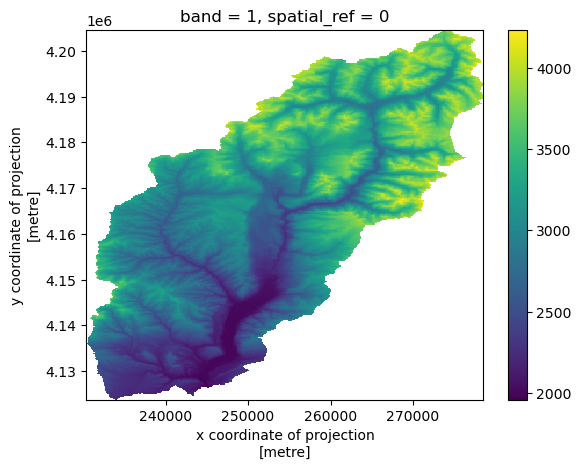

In [213]:
basin = ucrb_hcdn_basins[ucrb_hcdn_basins.gage=='09361500']
clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
clipped_dem_ma = clipped_dem.where(clipped_dem>0)
clipped_dem_ma.plot()

In [214]:
sorted_dropped_elevations = np.sort(np.ma.compressed(clipped_dem_ma))
sorted_dropped_nan_elevations = sorted_dropped_elevations[~np.isnan(sorted_dropped_elevations)]

sorted_dropped_areas = np.ma.compressed(area_array).cumsum()
sorted_dropped_nan_areas = sorted_dropped_areas[~np.isnan(sorted_dropped_elevations)]

NameError: name 'area_array' is not defined

In [304]:
sorted_dropped_nan_areas

array([1.97665765e-02, 3.95331530e-02, 5.92997295e-02, ...,
       2.00322393e+03, 2.00324370e+03, 2.00326346e+03])

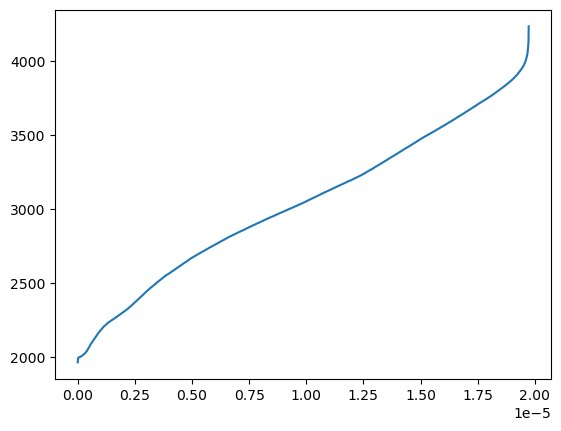

In [301]:
plt.plot(sorted_dropped_nan_areas/sorted_dropped_nan_areas.sum(),sorted_dropped_nan_elevations)

In [197]:
ydim = clipped_dem_ma.rio.transform()[0]
dx = ydim/1000
dy = ydim/1000
# Used to calculate the area of each pixel.
if ydim < 0:
    yres = ydim * -1.0
# array with indices
rows, cols = np.indices(clipped_dem_ma.shape) 
nrows = clipped_dem_ma.shape[0]
ncols = clipped_dem_ma.shape[1]

# new array for area values
area_array = np.empty(clipped_dem_ma.shape)

# nested loop to create array with area values
for row in range(nrows):
    for col in range(ncols):
        area_array[row,col] = dx * dy

In [188]:
# elevation 5M
clip_ma = np.ma.masked_where(clipped_dem_ma.isnull(), clipped_dem_ma)
clip_min = clipped_dem_ma.min()
clip_max = clipped_dem_ma.max()

# height of point/contour above base of basin
clip_array_comp = np.ma.compressed(clip_ma)
h_clip = clipped_dem_ma - clip_min

# total height of basin
H_clip = clip_max - clip_min

# normalize elev for hypsometric curve
elevNorm_clip = h_clip / H_clip


Make a masked array of cell area and calculate Area values used in hypsometric analysis

In [219]:
# cell area 5M
area_clip = area_array
# total area of basin/area
area_clip_sum = np.sum(area_clip)
# cumulative area for hypsographyc curve
area_clip_csum = np.cumsum(np.ma.compressed(area_clip))
# normalized area for hypsometric curve
area_norm_clip = area_clip / area_clip_sum
area_norm_csum = np.cumsum(np.ma.compressed(area_norm_clip))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


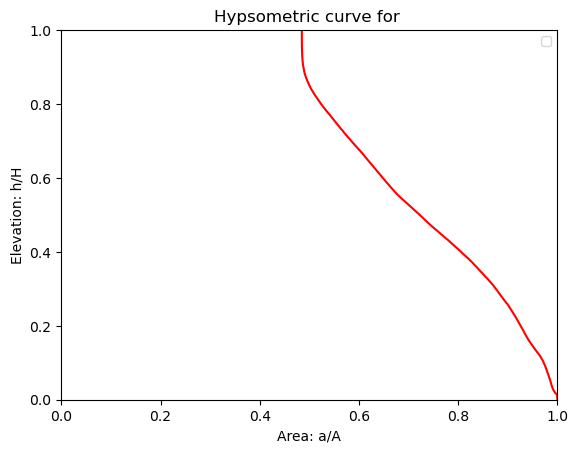

In [220]:
# 5M
plt.plot(area_norm_csum[::-1], np.sort(np.ma.compressed(elevNorm_clip)), c='r')

# decorations
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.ylabel('Elevation: h/H')
plt.xlabel('Area: a/A')
plt.title('Hypsometric curve for ')
lg = plt.legend(loc='upper right', fontsize=9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


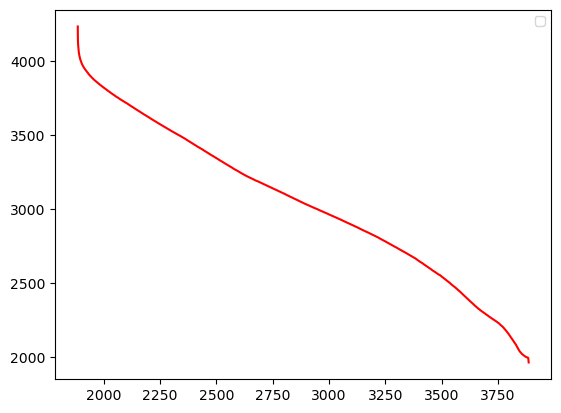

In [221]:
# 5M
plt.plot(area_clip_csum[::-1], np.sort(np.ma.compressed(clipped_dem_ma)), c='r')

# plt.ylim(0.0, 5000.0)
lg = plt.legend(loc='upper right', fontsize=9)

In [154]:
# auxiliar functions
def roundBase(x, base=5):
    return int(base * round(float(x)/base))

def roundUp(x, base=50):
    return int(base * np.ceil(float(x)/base))

def roundDown(x, base=50):
    return int(base * np.floor(float(x)/base))


In [246]:
clip_range

array([1961, 1962, 1963, ..., 4229, 4230, 4231])

In [249]:
# ii) calculating area per elevation
from scipy import ndimage
# define bins for all histograms
binsize = 500

clip_range = np.arange(0, int(clip_max)+1)

sum_area_clip = ndimage.sum(area_array, clipped_dem_ma, clip_range)

# sum the values of areas in each bin
bins_sum = []
for i in bincenters:
    low = i - (binsize / 2)
    up = i + (binsize / 2)
    b_sum = np.sum(sum_area_clip[int(low):int(up)])
    bins_sum.append(b_sum)
    

In [215]:
monthly_sntl_precip = hcdn_sntl_swe_ds.resample(Date='1M').max()
monthly_sntl_precip['WY'] = monthly_sntl_precip.Date.dt.year.where(monthly_sntl_precip.Date.dt.month<10,monthly_sntl_precip.Date.dt.year+1)

In [216]:
# Month order for water years
months = [10,11,12,1,2,3,4,5,6,7,8,9]
# Each year within the wrf dataset
years = monthly_sntl_precip.WY.groupby(monthly_sntl_precip.WY).mean().values

# 
for i,wy in enumerate(years):
    print(f'Working on {wy}')
    precip = [10,11,12,1,2,3,4,5,6,7,8,9]
    precip[0] = monthly_sntl_precip.where((monthly_sntl_precip.WY==wy) & (monthly_sntl_precip.Date.dt.month==10)).PREC
    precip[1:] = monthly_sntl_precip.where(monthly_sntl_precip.WY==wy).PREC.diff(dim='Date')
    if i == 0:
        monthly_precip_ds = xr.concat(precip, dim='Date')
    else:
        monthly_precip_ds = monthly_precip_ds.combine_first(xr.concat(precip, dim='Date'))



Working on 1979.0
Working on 1980.0
Working on 1981.0
Working on 1982.0
Working on 1983.0
Working on 1984.0
Working on 1985.0
Working on 1986.0
Working on 1987.0
Working on 1988.0
Working on 1989.0
Working on 1990.0
Working on 1991.0
Working on 1992.0
Working on 1993.0
Working on 1994.0
Working on 1995.0
Working on 1996.0
Working on 1997.0
Working on 1998.0
Working on 1999.0
Working on 2000.0
Working on 2001.0
Working on 2002.0
Working on 2003.0
Working on 2004.0
Working on 2005.0
Working on 2006.0
Working on 2007.0
Working on 2008.0
Working on 2009.0
Working on 2010.0
Working on 2011.0
Working on 2012.0
Working on 2013.0
Working on 2014.0
Working on 2015.0
Working on 2016.0
Working on 2017.0
Working on 2018.0
Working on 2019.0
Working on 2020.0
Working on 2021.0
Working on 2022.0


In [219]:
for site in range(len(basin_seasonal_fractions_ds.variable)):
    seasonal_drought_1930s = basin_seasonal_fractions_ds.isel(dim_1=0, variable=site).sel(month=drought_1930s)
    seasonal_means_drought_1930s = seasonal_drought_1930s.groupby(seasonal_drought_1930s.month.dt.month).mean().to_series()

    seasonal_drought_1970s = basin_seasonal_fractions_ds.isel(dim_1=0, variable=site).sel(month=drought_1970s)
    seasonal_means_drought_1970s = seasonal_drought_1970s.groupby(seasonal_drought_1970s.month.dt.month).mean().to_series()

    seasonal_drought_1980s = basin_seasonal_fractions_ds.isel(dim_1=0, variable=site).sel(month=drought_1980s)
    seasonal_means_drought_1980s = seasonal_drought_1980s.groupby(seasonal_drought_1980s.month.dt.month).mean().to_series()

    seasonal_drought_2000s = basin_seasonal_fractions_ds.isel(dim_1=0, variable=site).sel(month=drought_2000s)
    seasonal_means_drought_2000s = seasonal_drought_2000s.groupby(seasonal_drought_2000s.month.dt.month).mean().to_series()

    seasonal_drought_2010s = basin_seasonal_fractions_ds.isel(dim_1=0, variable=site).sel(month=drought_2010s)
    seasonal_means_drought_2010s = seasonal_drought_2010s.groupby(seasonal_drought_2010s.month.dt.month).mean().to_series()

    seasonal_means_drought_1930s.plot(color='grey')
    # seasonal_means_drought_1970s.plot(color='k')
    # seasonal_means_drought_1980s.plot(color='g')
    # seasonal_means_drought_2000s.plot(color='b')
    seasonal_means_drought_2010s.plot(color='r')

NameError: name 'basin_seasonal_fractions_ds' is not defined

In [218]:
seasonal_drought_1930s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_1930s)
seasonal_means_drought_1930s = seasonal_drought_1930s.groupby(seasonal_drought_1930s.month.dt.month).mean().to_series()

seasonal_drought_1970s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_1970s)
seasonal_means_drought_1970s = seasonal_drought_1970s.groupby(seasonal_drought_1970s.month.dt.month).mean().to_series()

seasonal_drought_1980s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_1980s)
seasonal_means_drought_1980s = seasonal_drought_1980s.groupby(seasonal_drought_1980s.month.dt.month).mean().to_series()

seasonal_drought_2000s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_2000s)
seasonal_means_drought_2000s = seasonal_drought_2000s.groupby(seasonal_drought_2000s.month.dt.month).mean().to_series()

seasonal_drought_2010s = basin_seasonal_ppt_fractions_ds.isel(dim_1=0, variable=25).sel(month=drought_2010s)
seasonal_means_drought_2010s = seasonal_drought_2010s.groupby(seasonal_drought_2010s.month.dt.month).mean().to_series()

In [35]:
import scipy.stats as stats

NameError: name 'seasonal_means_drought_1930s' is not defined

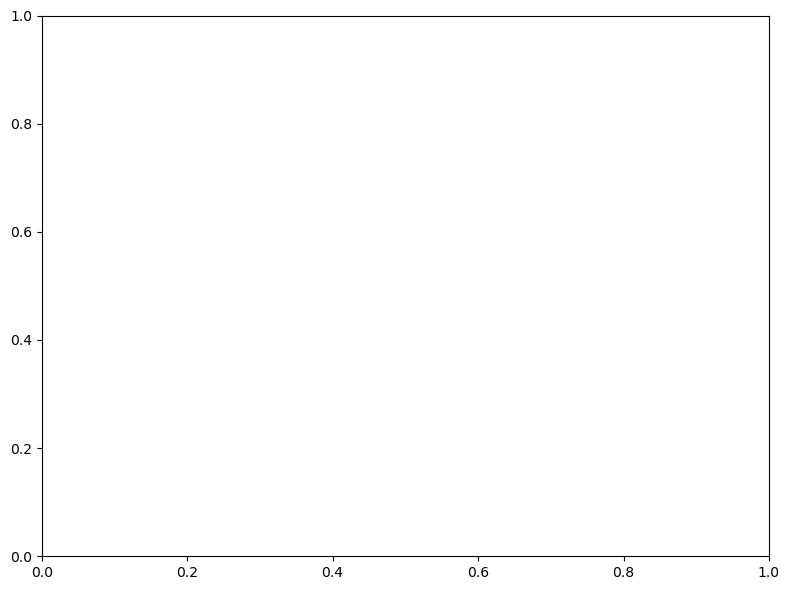

In [39]:
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True, sharex=True)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
x1=[0,1,2,3,4]
x2 = [0.15,1.15,2.15,3.15,4.15]
x3 = [0.3,1.3,2.3,3.3,4.3]
x4 = [0.45,1.45,2.45,3.45,4.45]
location = [x1,x2,x3,x4]

fall_means = [
        seasonal_means_drought_1930s.loc[seasonal_means_drought_1930s.index==9].values[0],
        seasonal_means_drought_1970s.loc[seasonal_means_drought_1970s.index==9].values[0],
        seasonal_means_drought_1980s.loc[seasonal_means_drought_1980s.index==9].values[0],
        seasonal_means_drought_2000s.loc[seasonal_means_drought_2000s.index==9].values[0],
        seasonal_means_drought_2010s.loc[seasonal_means_drought_2010s.index==9].values[0],
    ]
winter_means = [
        seasonal_means_drought_1930s.loc[seasonal_means_drought_1930s.index==12].values[0],
        seasonal_means_drought_1970s.loc[seasonal_means_drought_1970s.index==12].values[0],
        seasonal_means_drought_1980s.loc[seasonal_means_drought_1980s.index==12].values[0],
        seasonal_means_drought_2000s.loc[seasonal_means_drought_2000s.index==12].values[0],
        seasonal_means_drought_2010s.loc[seasonal_means_drought_2010s.index==12].values[0],
    ]
spring_means = [
        seasonal_means_drought_1930s.loc[seasonal_means_drought_1930s.index==3].values[0],
        seasonal_means_drought_1970s.loc[seasonal_means_drought_1970s.index==3].values[0],
        seasonal_means_drought_1980s.loc[seasonal_means_drought_1980s.index==3].values[0],
        seasonal_means_drought_2000s.loc[seasonal_means_drought_2000s.index==3].values[0],
        seasonal_means_drought_2010s.loc[seasonal_means_drought_2010s.index==3].values[0],
    ]
summer_means = [
        seasonal_means_drought_1930s.loc[seasonal_means_drought_1930s.index==6].values[0],
        seasonal_means_drought_1970s.loc[seasonal_means_drought_1970s.index==6].values[0],
        seasonal_means_drought_1980s.loc[seasonal_means_drought_1980s.index==6].values[0],
        seasonal_means_drought_2000s.loc[seasonal_means_drought_2000s.index==6].values[0],
        seasonal_means_drought_2010s.loc[seasonal_means_drought_2010s.index==6].values[0],
    ]


fall = ax.bar(x=location[0],
    height=fall_means, width=0.15, label='Mean Autumn Precip Fraction',color=CB_color_cycle[1], ec='k')

winter = ax.bar(x=location[1],
    height=winter_means, width=0.15, label='Mean Winter Precip Fraction',color=CB_color_cycle[0], ec='k')

spring = ax.bar(x=location[2],
    height=spring_means, width=0.15, label='Mean Spring Precip Fraction',color=CB_color_cycle[3], ec='k')

summer = ax.bar(x=location[3],
    height=summer_means,width=0.15, label='Mean Summer Precip Fraction',color=CB_color_cycle[2], ec='k')

# Stylize
xticks = [0.3,1.3,2.3,3.3,4.3]
xticklabels = [
                '1930s Drought\n(Dust Bowl)',
                '1970s\nDrought',
                'Late 1980s\nDrought',
                'Early 2000s\nDrought',
                'Late 2010s\nDrought']
title = f'Seasonal Precipiation Fraction '
xlabel = ''
ylabel =  'Precipitation Fraction '

stylize_axes(ax, title, xlabel, ylabel, xticks, xticklabels, )
ax.legend(ncols=2,loc='upper left')
ax.axhline(0,color='k',lw=2)
ax.set_ylim(0,0.5)